In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
from scipy.stats import ttest_ind

# Load data

In [2]:
from load_ensembles import *

/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array)


In [3]:
var='GPP'

In [4]:
ensemble_coupled = load_coupled_ensemble(var=var, domain='lnd')
ensemble_offline = load_offline_ensemble(var=var, domain='lnd')

In [5]:
basecase_lnd_coupled=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/COUP0000_PI_SOM/lnd/proc/tseries/COUP0000_PI_SOM.clm2.h0.timeseries.'+var+'.nc')
basecase_lnd_coupled_mean = basecase_lnd_coupled[var][12*50:,:,:].mean(dim='time')

basecase_lnd_offline=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/offline_simulations/OFFL0000_PI_v02/lnd/proc/tseries/OFFL0000_PI_v02.clm2.h0.timeseries.'+var+'.nc')
basecase_lnd_offline_mean = basecase_lnd_offline[var][12*50:,:,:].mean(dim='time')

/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [6]:
basecase_lnd_mean=basecase_lnd_coupled_mean

# make grid

In [7]:
ds_grid = ensemble_coupled[0]

In [8]:
import make_multisimulation_dataset

In [9]:
var_array = make_multisimulation_dataset.make_empty_dataarray(ds_grid=ds_grid, var=var, keys=keys)
var_array_pvals =  make_multisimulation_dataset.make_empty_dataarray(ds_grid=ds_grid, var=var, keys=keys)

/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [10]:
season='Annual'#'Annual','DJF,'MAM','JJA','SON'
for i in np.arange(0,np.size(keys)):
    print(i)
    ds_coupled=ensemble_coupled[i][var]
    ds_offline=ensemble_offline[i][var]
    if season=='Annual':
        coupled_tseries=ds_coupled[60*12:,:,:].groupby('time.year').mean(dim='time')
        offline_tseries=ds_offline[60*12:,:,:].groupby('time.year').mean(dim='time')
    else:
        seasonfilter=ds_coupled['time.season']==season
        coupled_tseries=ds_coupled[60*12:,:,:].where(seasonfilter).groupby('time.year').mean(dim='time')
        offline_tseries=ds_offline[60*12:,:,:].where(seasonfilter).groupby('time.year').mean(dim='time')
    t, p = ttest_ind(coupled_tseries, offline_tseries, equal_var=False)
    diff = np.abs(coupled_tseries.mean(dim='year')-offline_tseries.mean(dim='year'))
    
    var_array[:,:,i]=diff
    var_array_pvals[:,:,i]=p

0


/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [11]:
from quick_map import *
mapdata=ensemble_coupled[0][var][0,:,:]

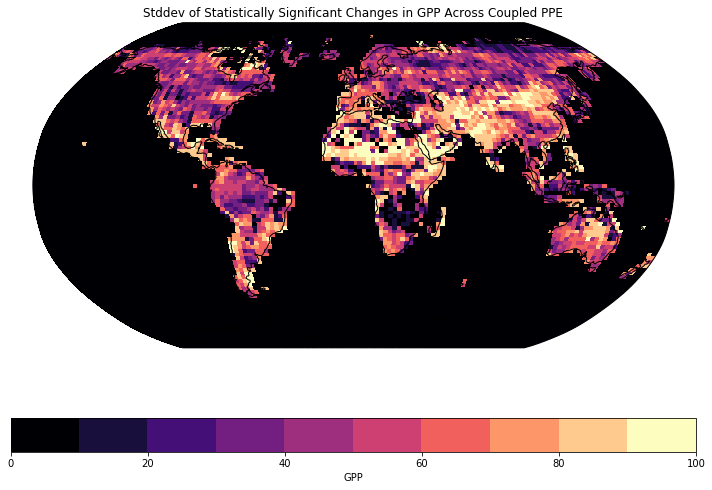

In [12]:
mapdata=((var_array_pvals>0.05).sum(dim='ensemble_key')*100/
         np.size(var_array_pvals['ensemble_key']))

fig=quick_map(mapdata, 
          title='Stddev of Statistically Significant Changes in '+var+' Across Coupled PPE',
          outpath='figures/VariationMaps_'+var+'_'+season+'.png',
          colorlabel=var)

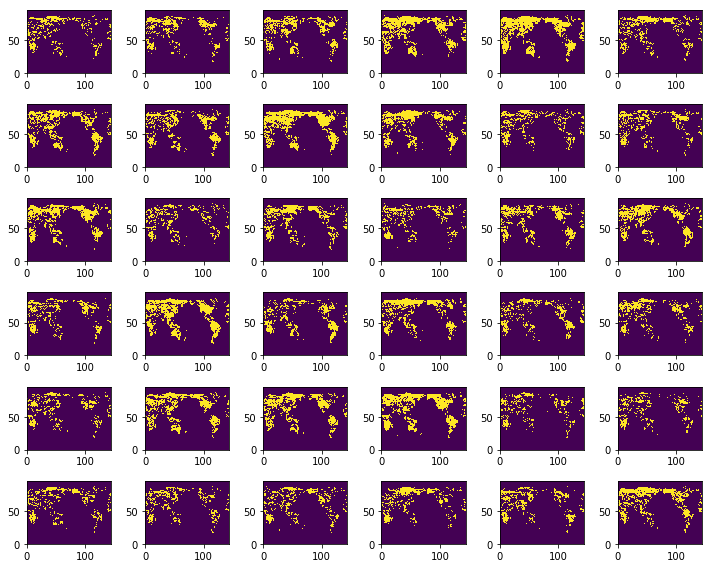

In [13]:
plt.figure(figsize=(10,8))
for i in np.arange(0, np.size(var_array_pvals['ensemble_key'])):
    plt.subplot(6,6,i+1)
    plt.pcolormesh((var_array_pvals<0.05)[:,:,i])
plt.tight_layout()

# Make figures

### Maps comparing coupled vs offline for each ensemble member

/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


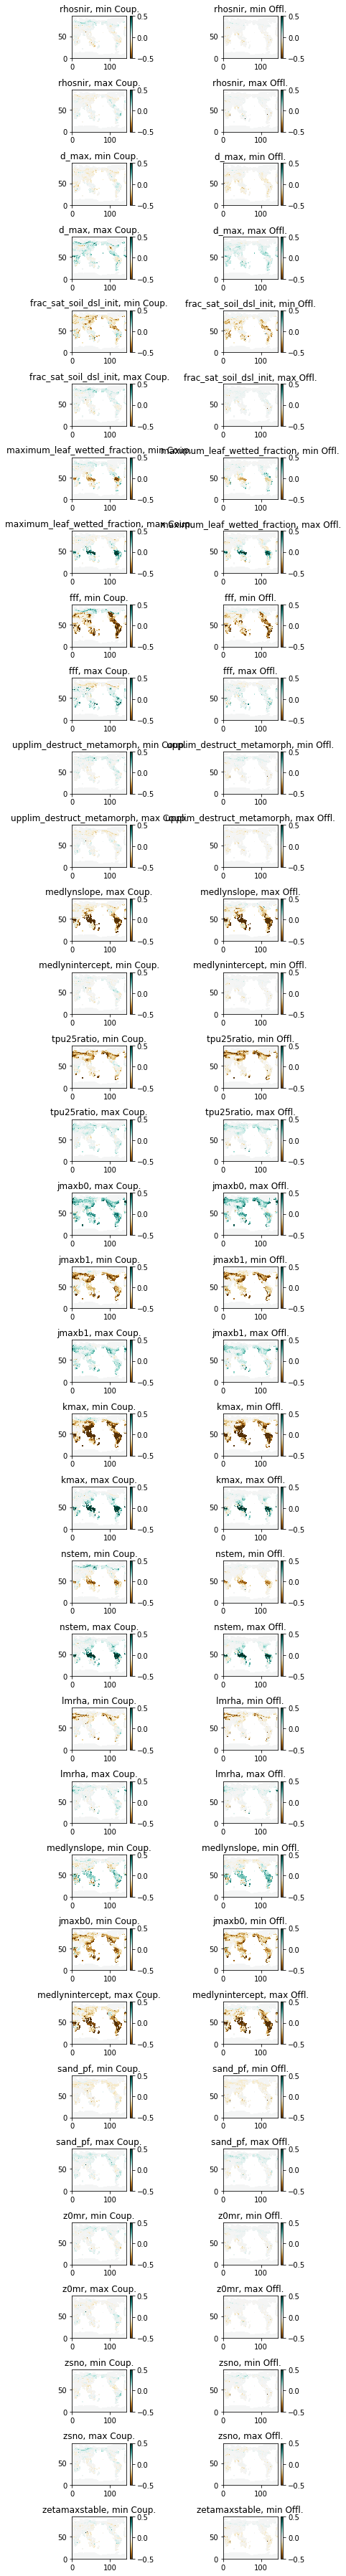

In [14]:
plt.figure(figsize=(6,50))
vmin=-0.5
vmax=0.5
nrow=35
unitconv=86400*365/1000
for i in np.arange(0,nrow):
    description=crosswalk['description'].values[i]
    sim_coupled = ensemble_coupled[i][var][12*50:,:,:].mean(dim='time')
    sim_offline = ensemble_offline[i][var][12*50:,:,:].mean(dim='time')
    diff_coupled=sim_coupled-basecase_lnd_mean
    diff_offline=sim_offline-basecase_lnd_mean
    key=keys[i]

    plt.subplot(nrow,2,(2*i+1))
    plt.pcolormesh(diff_coupled*unitconv, cmap=plt.cm.BrBG, vmin=vmin, vmax=vmax)
    plt.title(description+' Coup.')
    plt.colorbar()
    
    plt.subplot(nrow,2,(2*(i+1)))
    plt.pcolormesh(diff_offline*unitconv, cmap=plt.cm.BrBG, vmin=vmin, vmax=vmax)
    plt.title(description+' Offl.')
    plt.colorbar()
plt.tight_layout()

/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


0001


/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in less


0037
0007
0008
0009
0010
0013
0014
0015
0016
0017
0018
0019
0020
0021
0022
0023
0024
0025
0026
0027
0028
0029
0030
0031
0032
0033
0034
0035
0036
0003
0004
0005
0006
0011


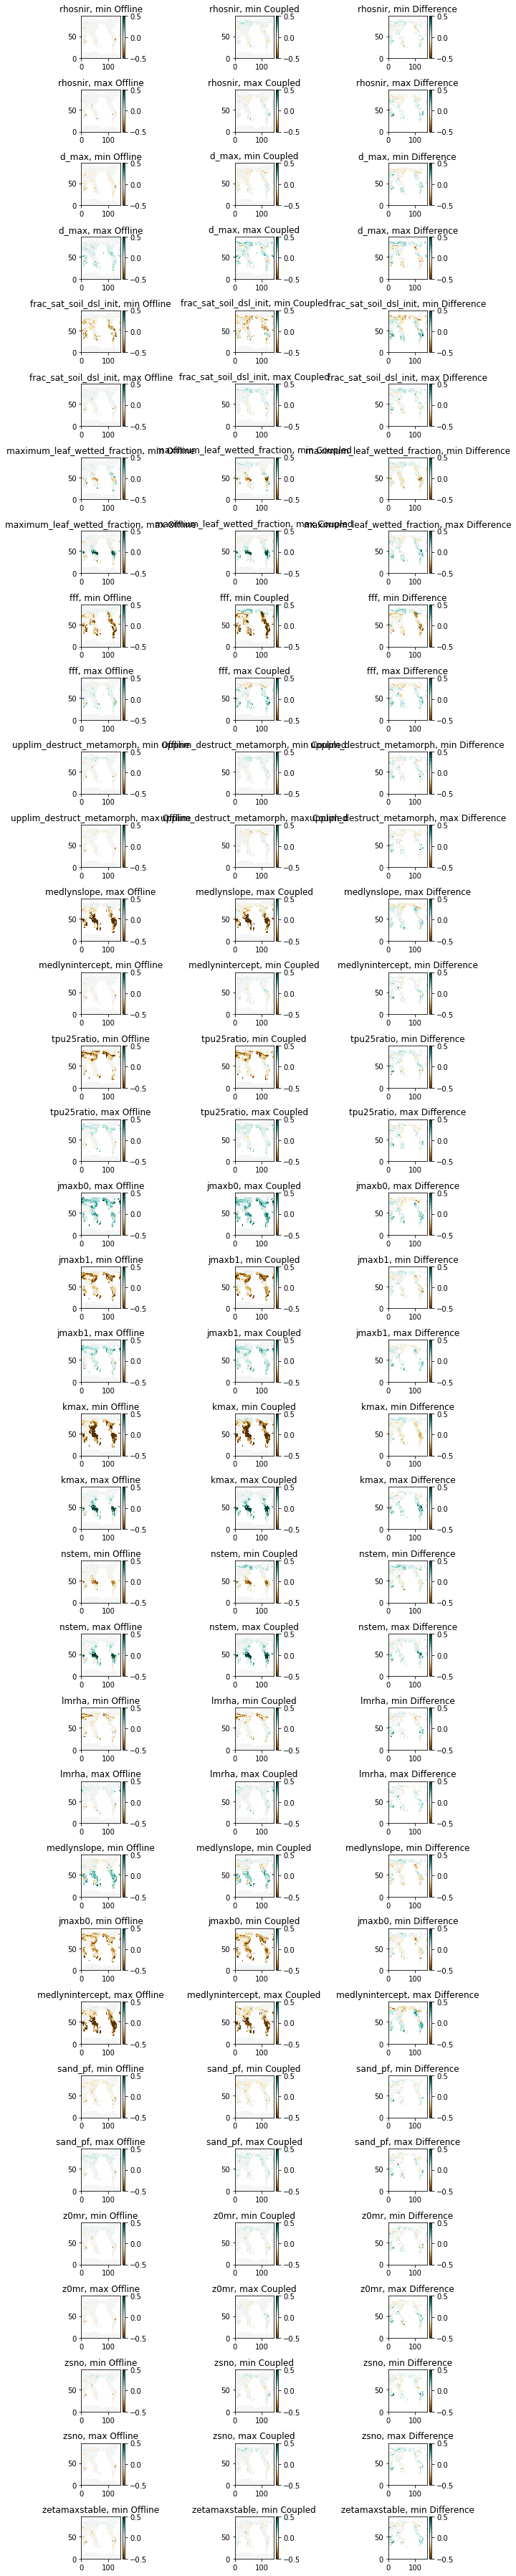

In [15]:
plt.figure(figsize=(9,50))
vmin=-0.5
vmax=0.5
unitconv=86400*365/1000
nrow=35
for i in np.arange(0,nrow):
    description=crosswalk['description'].values[i]
    sim_coupled = ensemble_coupled[i][var][12*50:,:,:].mean(dim='time')
    sim_offline = ensemble_offline[i][var][12*50:,:,:].mean(dim='time')
    diff_coupled=sim_coupled-basecase_lnd_mean
    diff_offline=sim_offline-basecase_lnd_mean
    diff_diff = diff_coupled-diff_offline
    diff_ratio = diff_coupled/diff_offline
    
    timeseries_coupled_grid=ensemble_coupled[i][var][12*50:,:,:].groupby('time.year').mean(dim='time').load()
    timeseries_offline_grid=ensemble_offline[i][var][12*50:,:,:].groupby('time.year').mean(dim='time').load()

    t, p = ttest_ind(timeseries_coupled_grid, timeseries_offline_grid, equal_var=False)

    key=keys[i]

    print(key)
    plt.subplot(nrow,3,(3*i)+2)
    plt.pcolormesh(diff_coupled*unitconv, cmap=plt.cm.BrBG, vmin=vmin, vmax=vmax)
    plt.title(description+' Coupled')
    plt.colorbar()
    
    plt.subplot(nrow,3,(3*i)+1)
    plt.pcolormesh(diff_offline*unitconv, cmap=plt.cm.BrBG, vmin=vmin, vmax=vmax)
    plt.title(description+' Offline')
    plt.colorbar()
    
    plt.subplot(nrow,3,(3*i)+3)
    plt.pcolormesh(diff_diff.where(p<0.05)*unitconv, cmap=plt.cm.BrBG, vmin=vmin, vmax=vmax)
    plt.title(description+' Difference')
    plt.colorbar()
plt.tight_layout()

# Zonal means for a single param

In [ ]:
HYDRO
frac_sat_soil_dsl_init: confusing
d_max: confusing
z0mr: confusing
zetamaxstable: confusing
fff: amplifying
upplim_destruct_metamorph: amplifying
sand_pf: confusing
zsno: confusing

PLANTS
--- amplifying
jmaxb0
jmaxb1
kmax

--- dampening
medlynintercept
medlynslope

--- confusing
lmrha
rhosnir
tpu25ratio

PLANT(ish)
maximum_leaf_wetted_fraction -- amplifying
nstem

In [18]:
for p in np.unique(crosswalk['param']):
    print(p)

d_max
fff
frac_sat_soil_dsl_init
jmaxb0
jmaxb1
kmax
lmrha
maximum_leaf_wetted_fraction
medlynintercept
medlynslope
nstem
rhosnir
sand_pf
tpu25ratio
upplim_destruct_metamorph
z0mr
zetamaxstable
zsno


In [150]:
minval=np.arange(0,36)[crosswalk['description'].values=='nstem, min']
maxval=np.arange(0,36)[crosswalk['description'].values=='nstem, max']
ds_coupled_min=ensemble_coupled[minval[0]]
ds_offline_min=ensemble_offline[minval[0]]
ds_coupled_max=ensemble_coupled[maxval[0]]
ds_offline_max=ensemble_offline[maxval[0]]

In [151]:
unitconv=86400*365/1000

In [152]:
ref=basecase_lnd_mean.mean(dim='lon')*unitconv

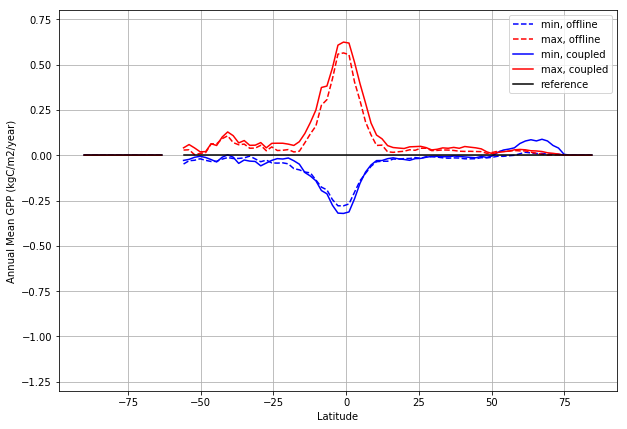

In [153]:
plt.figure(figsize=(10,7))
plt.plot(ds_offline_min.lat, ds_offline_min.GPP.mean(dim='time').mean(dim='lon')*unitconv-ref,'--b',
        label='min, offline')
plt.plot(ds_offline_max.lat, ds_offline_max.GPP.mean(dim='time').mean(dim='lon')*unitconv-ref,'--r', 
         label='max, offline')
plt.plot(ds_coupled.lat, ds_coupled_min.GPP.mean(dim='time').mean(dim='lon')*unitconv-ref,'-b',
        label='min, coupled')
plt.plot(ds_coupled_max.lat, ds_coupled_max.GPP.mean(dim='time').mean(dim='lon')*unitconv-ref,'-r',
        label='max, coupled')
plt.plot(ref.lat, ref-ref,'-k', 
         label='reference')
plt.xlabel('Latitude')
plt.ylabel('Annual Mean GPP (kgC/m2/year)')
plt.legend()
plt.ylim([-1.3, 0.8])
plt.grid()

### Scatter plot of correlations

In [14]:
plt.figure(figsize=(20,20))
nrow=35
unitconv=1
for i in np.arange(0,nrow):
    description=crosswalk['description'].values[i]
    sim_coupled = ensemble_coupled[i][var][12*50:,:,:].mean(dim='time')-basecase_lnd_coupled_mean
    sim_offline = ensemble_offline[i][var][12*50:,:,:].mean(dim='time')-basecase_lnd_coupled_mean
    diff_coupled=sim_coupled-basecase_lnd_mean
    diff_offline=sim_offline-basecase_lnd_mean
    key=keys[i]
    #print(key)

    sim_coupled_flat = sim_coupled.values.ravel()
    sim_offline_flat = sim_offline.values.ravel()
    sim_coupled_flat = sim_coupled_flat[~np.isnan(sim_coupled_flat)]
    sim_offline_flat = sim_offline_flat[~np.isnan(sim_offline_flat)]

    minval=-35#np.nanmin([np.nanmin(sim_offline_flat),np.nanmin(sim_coupled_flat)])
    maxval=40# np.nanmax([np.nanmax(sim_offline_flat),np.nanmax(sim_coupled_flat)])
    
    plt.subplot(6,6,i+1)
    plt.plot(sim_offline_flat, sim_coupled_flat, '.', alpha=0.3)
    plt.plot([minval, maxval],[minval, maxval],'-k')
    plt.plot([minval, maxval],[0, 0],'-k', alpha=0.3)
    plt.plot([0, 0],[minval, maxval],'-k', alpha=0.3)
    plt.title(description)
    plt.grid()
    plt.xlabel('Offline')
    plt.ylabel('Coupled')
plt.tight_layout()

NameError: name 'basecase_lnd_mean' is not defined

<Figure size 1440x1440 with 0 Axes>

### Other maps

0001


/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


0007


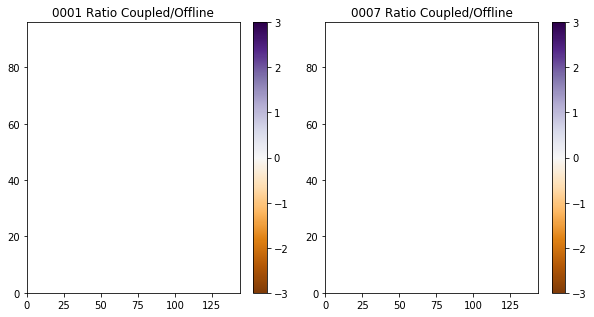

In [20]:
plt.figure(figsize=(25,25))
vmin=-0.3
vmax=0.3
nrow=2#35
for i in np.arange(0,nrow):
    sim_coupled = ensemble_coupled[i][var][12*50:,:,:].mean(dim='time')
    sim_offline = ensemble_offline[i][var][12*50:,:,:].mean(dim='time')
    diff_coupled=sim_coupled-basecase_lnd_mean
    diff_offline=sim_offline-basecase_lnd_mean
    diff_diff = diff_coupled-diff_offline
    diff_ratio = diff_coupled/diff_offline
    
    timeseries_coupled_grid=ensemble_coupled[i][var][12*50:,:,:].groupby('time.year').mean(dim='time').load()
    timeseries_offline_grid=ensemble_offline[i][var][12*50:,:,:].groupby('time.year').mean(dim='time').load()

    t, p = ttest_ind(timeseries_coupled_grid, timeseries_offline_grid, equal_var=False)

    key=keys[i]

    print(key)
    plt.subplot(6,6, i+1)
    plt.pcolormesh(diff_ratio.where(p<0.05).where(diff_offline>0.1), cmap=plt.cm.PuOr, vmin=-3, vmax=3)
    plt.title(key+' Ratio Coupled/Offline')
    plt.colorbar()
plt.tight_layout()

In [61]:
i=7
timeseries_coupled_grid=ensemble_coupled[i][var][12*50:,:,:].groupby('time.year').mean(dim='time').load()
timeseries_offline_grid=ensemble_offline[i][var][12*50:,:,:].groupby('time.year').mean(dim='time').load()

t, p = ttest_ind(timeseries_coupled_grid, timeseries_offline_grid, equal_var=False)

In [43]:
"""
import xarray.ufuncs as xrf
from scipy import stats
import xarray as xr


def ttest_1samp(a, popmean, dim):
    """
    This is a two-sided test for the null hypothesis that the expected value
    (mean) of a sample of independent observations `a` is equal to the given
    population mean, `popmean`
    
    Inspired here: https://github.com/scipy/scipy/blob/v0.19.0/scipy/stats/stats.py#L3769-L3846
    
    Parameters
    ----------
    a : xarray
        sample observation
    popmean : float or array_like
        expected value in null hypothesis, if array_like than it must have the
        same shape as `a` excluding the axis dimension
    dim : string
        dimension along which to compute test
    
    Returns
    -------
    mean : xarray
        averaged sample along which dimension t-test was computed
    pvalue : xarray
        two-tailed p-value
    """
    n = a[dim].shape[0]
    df = n - 1
    a_mean = a.mean(dim)
    d = a_mean - popmean
    v = a.var(dim, ddof=1)
    denom = xrf.sqrt(v / float(n))

    t = d /denom
    prob = stats.distributions.t.sf(xrf.fabs(t), df) * 2
    prob_xa = xr.DataArray(prob, coords=a_mean.coords)
    return a_mean, prob_xa
    """